In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment1

/home/pengyu.zhang/project/superres/ProbSR/Experiment1


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
from utils import *

## Generate Training Data

In [15]:
N_low = 41
N_high = 161
scale = 4

# Code downscaling matrix
H = np.zeros((N_low*N_low, N_high*N_high))

submatrix = np.zeros((N_low,N_high))
for i in range(N_low):
    submatrix[i,scale*i] = 1
    
for j in range(N_low):
    H[N_low*j:N_low*(j+1),N_high*scale*j:N_high*(scale*j+1)] = submatrix
    
for a in [4,8]:
    for b in tqdm(range(1,9)):
        for c in tqdm(range(1,9)):
            w_low = generate_data(N_low,a,b,c)[0]
            w_high = generate_data(N_high,a,b,c)[0]
            residual = w_low-(H@w_high.reshape(N_high*N_high)).reshape(N_low,N_low)
            # residual = w_low - cv2.resize(w_high,(N_low,N_low),interpolation=cv2.INTER_CUBIC)
            
            if a==4 and b == 1 and c == 1:
                total_low = w_low.reshape(1,N_low,N_low)
                total_high = w_high.reshape(1,N_high,N_high)
                total_residual = residual.reshape(1,N_low,N_low)
            else:
                total_low = np.concatenate([total_low,w_low.reshape(1,N_low,N_low)],axis=0)
                total_high = np.concatenate([total_high,w_high.reshape(1,N_high,N_high)],axis=0)
                total_residual = np.concatenate([total_residual,residual.reshape(1,N_low,N_low)],axis=0)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:32<00:00, 19.12s/it]


In [6]:
N_low = 40
N_high = 160
scale = 4

import random
for i in tqdm(range(8)):
    a = random.choice([4, 8])
    b = random.randint(1, 8)
    c = random.randint(1, 8)
    
    w_low = generate_data(N_low,a,b,c)[0]
    w_high = generate_data(N_high,a,b,c)[0]
    residual = w_low - cv2.resize(w_high,(N_low,N_low),interpolation=cv2.INTER_NEAREST)
    
    if i==0:
        total_low = w_low.reshape(1,N_low,N_low)
        total_high = w_high.reshape(1,N_high,N_high)
        total_residual = residual.reshape(1,N_low,N_low)
    else:
        total_low = np.concatenate([total_low,w_low.reshape(1,N_low,N_low)],axis=0)
        total_high = np.concatenate([total_high,w_high.reshape(1,N_high,N_high)],axis=0)
        total_residual = np.concatenate([total_residual,residual.reshape(1,N_low,N_low)],axis=0)

100%|██████████| 8/8 [00:19<00:00,  2.45s/it]


In [7]:
with h5py.File("data/DownBy4_40_160_small8.h5", 'w') as hf:
    hf.create_dataset("high_res",  data=total_high)
    hf.create_dataset("low_res",  data=total_low)
    hf.create_dataset("residual", data=total_residual)

In [ ]:
N_low = 40
N_high = 160
scale = 4
a,b,c = 4,1,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

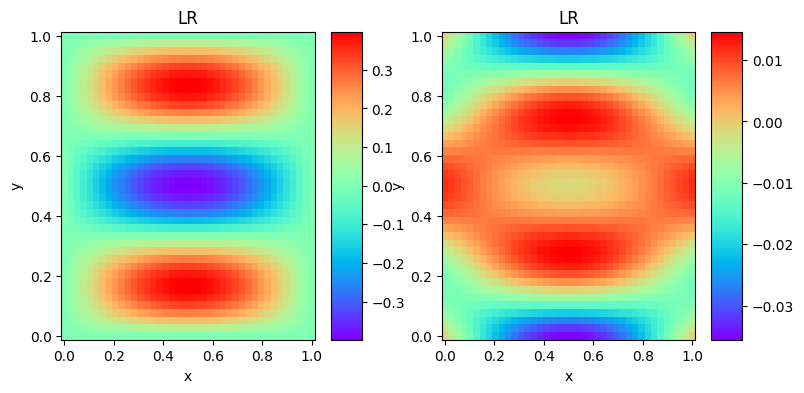

In [14]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, total_low[2], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, total_residual[2], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.05, 0.05)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
N_low = 40
N_high = 160
scale = 4

# Code downscaling matrix
'''H = np.zeros((N_low*N_low, N_high*N_high))

submatrix = np.zeros((N_low,N_high))
for i in range(N_low):
    submatrix[i,scale*i] = 1
    
for j in range(N_low):
    H[N_low*j:N_low*(j+1),N_high*scale*j:N_high*(scale*j+1)] = submatrix'''
    
for a in [4,8]:
    for b in tqdm(range(1,9)):
        for c in tqdm(range(1,9)):
            w_low = generate_data(N_low,a,b,c)[0]
            b_high = create_forcing_term(N_high,a,b,c)
            b_low = create_forcing_term(N_low,a,b,c)
            
            if a==4 and b == 1 and c == 1:
                total_low = w_low.reshape(1,N_low,N_low)
                total_high_forcing = b_high.reshape(1,N_high**2,1)
                total_low_forcing = b_low.reshape(1,N_low**2,1)
            else:
                total_low = np.concatenate([total_low,w_low.reshape(1,N_low,N_low)],axis=0)
                total_high_forcing = np.concatenate([total_high_forcing,b_high.reshape(1,N_high**2,1)],axis=0)
                total_low_forcing = np.concatenate([total_low_forcing,b_low.reshape(1,N_low**2,1)],axis=0)

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


In [9]:
with h5py.File("data/40_160_low_forcing_withlow.h5", 'w') as hf:
    hf.create_dataset("low_res",  data=total_low)
    hf.create_dataset("high_forcing", data=total_high_forcing)
    hf.create_dataset("low_forcing", data=total_low_forcing)